In [ ]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [ ]:
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras

from keras import optimizers



from progressbar import ProgressBar

import matplotlib.pylab as plt
import seaborn as sns
sns.set_style('whitegrid')

In [ ]:
def fn_divide(a, b): return np.divide(a+1e-6, b+1e-6)


def fn_standardize_df(df_tr_, df_ts_):

    from sklearn.preprocessing import StandardScaler
    df_tr, df_ts = df_tr_, df_ts_
    X_train, X_test = df_tr.iloc[:, :-1].values, df_ts.iloc[:, :-1].values

    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test  = scaler.transform(X_test)

    df_tr = pd.DataFrame(X_train, columns = df_tr.columns[:-1]).assign(labels = df_tr.labels.values)
    df_ts = pd.DataFrame(X_test, columns  = df_ts.columns[:-1]).assign(labels = df_ts.labels.values)

    return df_tr, df_ts, scaler


def fn_acc(con_matrix):

    actual_total = con_matrix.sum(axis = 1)
    correct_preds = con_matrix.diagonal()
    acc = fn_divide(correct_preds.sum(), actual_total.sum())
    return np.round(100*acc, 3)



def fn_logloss(model_, X_, y_, labels = [0, 1]):

    y_pred = model_.predict(X_)
    bce = tf.keras.losses.BinaryCrossentropy()
    loss = bce(y_.reshape(-1, 1), y_pred.reshape(-1, 1)).numpy()
    return loss.item()



def fn_con_matrix_binary(model_, X_, y_, threshold_class_1 = 0.5):

    from sklearn.metrics import confusion_matrix

    proba_cls_1 = model_.predict(X_)

    y_pred = np.array([1 if i > threshold_class_1 else 0 for i in proba_cls_1])

    con_matrix = confusion_matrix(y_, y_pred)

    return con_matrix



def fn_prec_vec(con_matrix):

    pred_total = con_matrix.sum(axis = 0)
    correct_preds = con_matrix.diagonal()
    prec_vec = fn_divide(correct_preds, pred_total)

    return 100*prec_vec.round(3)



def fn_rec_vec(con_matrix):

    actual_total = con_matrix.sum(axis = 1)
    correct_preds = con_matrix.diagonal()
    rec_vec = fn_divide(correct_preds, actual_total)

    return 100*rec_vec.round(3)



def fn_model_perform_thresholds(model_, X_, y_, listO_thresh_cls_1, NN=False):

    from sklearn.metrics import confusion_matrix
    if NN == False:
        probas_both_cls = model_.predict_proba(X_)
        proba_cls_1 = probas_both_cls[:, 1]
    else:
        proba_cls_1 = model_.predict(X_)

    listO_metrics = []

    for thresh in listO_thresh_cls_1:
        y_pred = np.array([1 if i > thresh else 0 for i in proba_cls_1])
        con_matrix = confusion_matrix(y_, y_pred)
        prec_vec, rec_vec = fn_prec_vec(con_matrix), fn_rec_vec(con_matrix)
        listO_metrics.append([*prec_vec, *rec_vec, thresh])

    df_model_perform_thresholds = pd.DataFrame(np.array(listO_metrics))
    df_model_perform_thresholds.columns = ['prec_0', 'prec_1', 'rec_0', 'rec_1', 'thresh']

    return df_model_perform_thresholds





def fn_performance_models_data(listO_models, df_Xy_, legend, NN = False,
                               listO_thresh_cls_1 = np.linspace(0, 1, 10),
                               figsize=(15, 10)):

    X_test, y_test = df_Xy_.iloc[:, :-1].values, df_Xy_.iloc[:, -1].values

    plot_1, plot_2 = 'thresh rec_1', 'thresh prec_1'
    plot_3, plot_4 = 'thresh rec_0', 'thresh prec_0'

    listO_plot_titles = [plot_1, plot_2, plot_3, plot_4]
    subplot_grid = [2, 2]

    fig, axes = plt.subplots(*subplot_grid, figsize=figsize, sharey = False)
    axes = axes.ravel()
    for plot_n, title in enumerate(listO_plot_titles):
        x_axis, y_axis = title.split()

        for idx, model in enumerate(listO_models):

            df_model_perform_thresholds = fn_model_perform_thresholds(model, X_test, y_test,
                                                                      listO_thresh_cls_1 = listO_thresh_cls_1,
                                                                      NN = NN)
            df = df_model_perform_thresholds.sort_values(by = x_axis)
            axes[plot_n].plot(df[x_axis], df[y_axis], label = f'{legend[idx]}')
            title_1 = x_axis + ' - ' + y_axis
            axes[plot_n].set_xlabel(x_axis.upper())
            axes[plot_n].set_ylabel(y_axis.upper())
            axes[plot_n].set_title(title_1.upper())

        axes[plot_n].legend(prop={'size':12})

    plt.tight_layout()



def fn_test_model_binary_clf(df_Xy_, model_, threshold_class_1 = 0.5):

    df, model = df_Xy_, model_
    X, y = df.iloc[:, :-1].values, df.iloc[:, -1].values.ravel()

    con_matrix = fn_con_matrix_binary(model, X, y, threshold_class_1 = threshold_class_1)
    loss = fn_logloss(model, X, y)
    acc =  fn_acc(con_matrix)
    prec_vec = fn_prec_vec(con_matrix)
    rec_vec  = fn_rec_vec(con_matrix)

    df = pd.DataFrame().assign(prec = prec_vec, rec = rec_vec)
    df.index = ['class_' + str(i) for i in range(len(df))]
    print('--------------------')
    print(f'LOGLOSS : {round(loss, 4)}')
    print(f'ACCURACY: {round(acc, 3)}')
    print('--------------------')
    print()

    return df.round(3)

In [ ]:
def fn_NN_binary_clf(model, optimizer, df_tr, df_ts, model_save_path, batch_size=2048,
                     epochs=5, class_weight = {0:50, 1:50}):

    from tqdm.keras import TqdmCallback

    def fn_binary_metrics(df_history):

        df = df_history+1e-6
        TP, TN = df.TP.values, df.TN.values
        FP, FN = df.FP.values, df.FN.values
        rec_1,   rec_0 = TP/(TP+FN), TN/(TN+FP)
        prec_1, prec_0 = TP/(TP+FP), TN/(TN+FN)

        val_TP, val_TN = df.val_TP.values, df.val_TN.values
        val_FP, val_FN = df.val_FP.values, df.val_FN.values
        val_rec_1,   val_rec_0 = val_TP/(val_TP+val_FN), val_TN/(val_TN+val_FP)
        val_prec_1, val_prec_0 = val_TP/(val_TP+val_FP), val_TN/(val_TN+val_FN)

        diff_rec_1, diff_prec_1 = abs(rec_1 - val_rec_1), abs(prec_1 - val_prec_1)
        diff_rec_0, diff_prec_0 = abs(rec_0 - val_rec_0), abs(prec_0 - val_prec_0)

        return dict(tr_loss =  df.loss, ts_loss = df.val_loss,
                    tr_rec_1 = rec_1, tr_rec_0 = rec_0,
                    tr_prec_1 = prec_1, tr_prec_0 = prec_0,
                    diff_rec_1 = diff_rec_1, diff_prec_1 = diff_prec_1,
                    diff_rec_0 = diff_rec_0, diff_prec_0 = diff_prec_0)

    X_tr = df_tr.iloc[:, :-1].values
    X_ts = df_ts.iloc[:, :-1].values
    y_tr = df_tr.iloc[:, -1].values
    y_ts = df_ts.iloc[:, -1].values

    metrics =  [keras.metrics.TruePositives(name='TP'),
                keras.metrics.TrueNegatives(name='TN'),
                keras.metrics.FalsePositives(name='FP'),
                keras.metrics.FalseNegatives(name='FN')]

    model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=metrics)
    if model_save_path != None:
        call_back_1 = [keras.callbacks.ModelCheckpoint(model_save_path + model.name + '_epoch_{epoch}.h5')]
    call_back_2 = [TqdmCallback(verbose=0)]

    callbacks = call_back_2 if model_save_path == None else call_back_1 + call_back_2
    model_history = model.fit(X_tr, y_tr, validation_data=(X_ts, y_ts),
                                batch_size=batch_size,
                                    epochs=epochs,
                                 callbacks=callbacks,
                              class_weight=class_weight,
                                   verbose=0)

    df_history = pd.DataFrame(model_history.history)
    df_perform = pd.DataFrame().assign(**fn_binary_metrics(df_history))
    df_perform.index = [model.name + f'_epoch_{i}' for i in range(len(df_perform))]

    return df_perform, df_history

In [ ]:
def fn_embed_words_as_nums(corpus):
    dictO_word_embeds = {}
    pbar = ProgressBar()
    for sentence in pbar(corpus):
        for word in sentence.split():
            if word not in dictO_word_embeds:
                # Assign a unique index to each unique word:
                dictO_word_embeds[word] = (len(dictO_word_embeds) + 1)
                # Note that we don't attribute index 0 to anything.

    return dictO_word_embeds

In [ ]:
def fn_embed_docs(corpus, dictO_word_embeds, max_lg = 30):
    from keras.preprocessing.sequence import pad_sequences

    pbar = ProgressBar()
    listO_doc_vecs = []
    for doc in pbar(corpus):
        listO_words = doc.split()

        doc_vec = [dictO_word_embeds.get(word, 0) for word in listO_words]
        doc_vec = [num for num in doc_vec if num != 0][: max_lg]
        listO_doc_vecs.append(doc_vec)

    listO_padded_doc_vecs = pad_sequences(listO_doc_vecs)
    arryO_doc_vecs = np.array(listO_padded_doc_vecs)
    return arryO_doc_vecs

# DATA:


In [ ]:
data_path = 'gdrive/My Drive/3A_PGD/CODE_PGD/LSTM/'

df_nlp_tr = pd.read_csv(data_path + 'df_nlp_tr.csv')
df_nlp_ts = pd.read_csv(data_path + 'df_nlp_ts.csv')

df_nlp_tr.sample(5)

,prod_id,reviews,ratings
7903,b000evqwhu,i bought them being familiar with the taste in...,1
120460,b003vxe46y,i had bought pre bottled drinks with chia seed...,1
62454,b000g2uuos,i am a vegetarian trying to work more protein ...,1
68058,b0015z1ly8,i was expecting the minichews to be harder for...,0
121758,b001d0kg4q,pretty good selection and with the teas and th...,1


## CONVERTING TEXT INTO INTEGER EMBEDDING:

In [ ]:
corpus = df_nlp_tr.reviews.values
dictO_word_embeds = fn_embed_words_as_nums(corpus)

100% (147659 of 147659) |################| Elapsed Time: 0:00:02 Time:  0:00:02


In [ ]:
vocab_size = len(dictO_word_embeds)
vocab_size

65854

In [ ]:
tr_corpus = df_nlp_tr.reviews.values
ts_corpus = df_nlp_ts.reviews.values

tr_embeddings = fn_embed_docs(tr_corpus, dictO_word_embeds, max_lg = 50)
ts_embeddings = fn_embed_docs(ts_corpus, dictO_word_embeds, max_lg = 50)

tr_embeddings.shape, ts_embeddings.shape

100% (147659 of 147659) |################| Elapsed Time: 0:00:05 Time:  0:00:05
100% (36915 of 36915) |##################| Elapsed Time: 0:00:01 Time:  0:00:01


((147659, 50), (36915, 50))

In [ ]:
tr_embeddings

array([[   1,    2,    3, ...,   10,   40,   41],
       [  45,   47,   83, ...,   98,   10,  110],
       [ 176,   72,   10, ...,  230,  231,    7],
       ...,
       [   0,    0,    0, ...,  161,   20, 1060],
       [   0,    0,    0, ...,  548,   26,  151],
       [  52, 1504,   47, ...,  102,   52,  203]], dtype=int32)

In [ ]:
y_tr = df_nlp_tr.ratings.values
y_ts = df_nlp_ts.ratings.values

y_tr.shape, y_ts.shape

((147659,), (36915,))

In [ ]:
df_tr = pd.DataFrame(tr_embeddings).assign(labels = y_tr)
df_ts = pd.DataFrame(ts_embeddings).assign(labels = y_ts)

df_tr.shape, df_ts.shape

((147659, 51), (36915, 51))

# MODEL:  (STACKED LSTMs)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout

In [ ]:
model = Sequential(name = 'rnn_a')

model.add(Embedding(vocab_size+1, 100))

model.add(LSTM(100, return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(100, return_sequences=True))
model.add(LSTM(50, return_sequences=False))

model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "rnn_a"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 100)         6585500   
_________________________________________________________________
lstm_9 (LSTM)                (None, None, 100)         80400     
_________________________________________________________________
dropout_3 (Dropout)          (None, None, 100)         0         
_________________________________________________________________
lstm_10 (LSTM)               (None, None, 100)         80400     
_________________________________________________________________
lstm_11 (LSTM)               (None, 50)                30200     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 6,776,551
Trainable params: 6,776,551
Non-trainable params: 0
___________________________________________________

### TRAINING & EVAL:

In [ ]:
model = model
optimizer=tf.keras.optimizers.Adamax()

df_tr_, df_ts_ = df_tr, df_ts
model_save_path =  data_path + 'RNN_MODELS/model_a/'

batch_size, epochs = 150, 15
class_bias = {0:87, 1:13}

z = fn_NN_binary_clf(model, optimizer, df_tr_, df_ts_, model_save_path,
                     batch_size=batch_size, epochs=epochs,
                     class_weight = class_bias)

df_performance_model_rnn_2, df_history_rnn_2 = z

## STATISTICAL PERFORMANCE  OVERVIEW

In [ ]:
regd_columns = 'tr_prec_1 tr_rec_1 tr_prec_0 tr_rec_0 diff_rec_1 diff_rec_0'.split()
df_performance_model_rnn_2.loc[:, regd_columns].describe()

,tr_prec_1,tr_rec_1,tr_prec_0,tr_rec_0,diff_rec_1,diff_rec_0
count,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000
mean,0.984756,0.849473,0.511704,0.922136,0.033688,0.125656
std,0.010158,0.048003,0.086707,0.047395,0.019906,0.075486
min,0.959778,0.729235,0.330004,0.813570,0.000488,0.002741
25%,0.979392,0.825256,0.456212,0.894090,0.023015,0.066479
50%,0.987048,0.857208,0.516727,0.931381,0.028927,0.139738
75%,0.992798,0.884281,0.576604,0.960882,0.048543,0.179482
max,0.995830,0.909256,0.638272,0.976774,0.064146,0.263945


# FILTERING OUT BEST MODELS:

In [ ]:
dff = df_performance_model_rnn_2
df1 = dff[dff.diff_rec_0 < 0.06]
df2 = df1[df1.diff_rec_1 < 0.06]
df3 = df2[df2.tr_rec_0 > 0.6]
df_filtered_2 = df3[df3.tr_rec_0 > 0.6]
df_filtered_2.loc[:, regd_columns]

,tr_prec_1,tr_rec_1,tr_prec_0,tr_rec_0,diff_rec_1,diff_rec_0
rnn_a_epoch_1,0.971793,0.794881,0.407122,0.859252,0.028927,0.002741
rnn_a_epoch_3,0.978286,0.821422,0.449293,0.888777,0.022929,0.046884


## MODEL EVALUATION:

In [ ]:
def fn_load(model_name, model_save_path = model_save_path):
    model_name = model_save_path + model_name + '.h5'
    return keras.models.load_model(model_name)

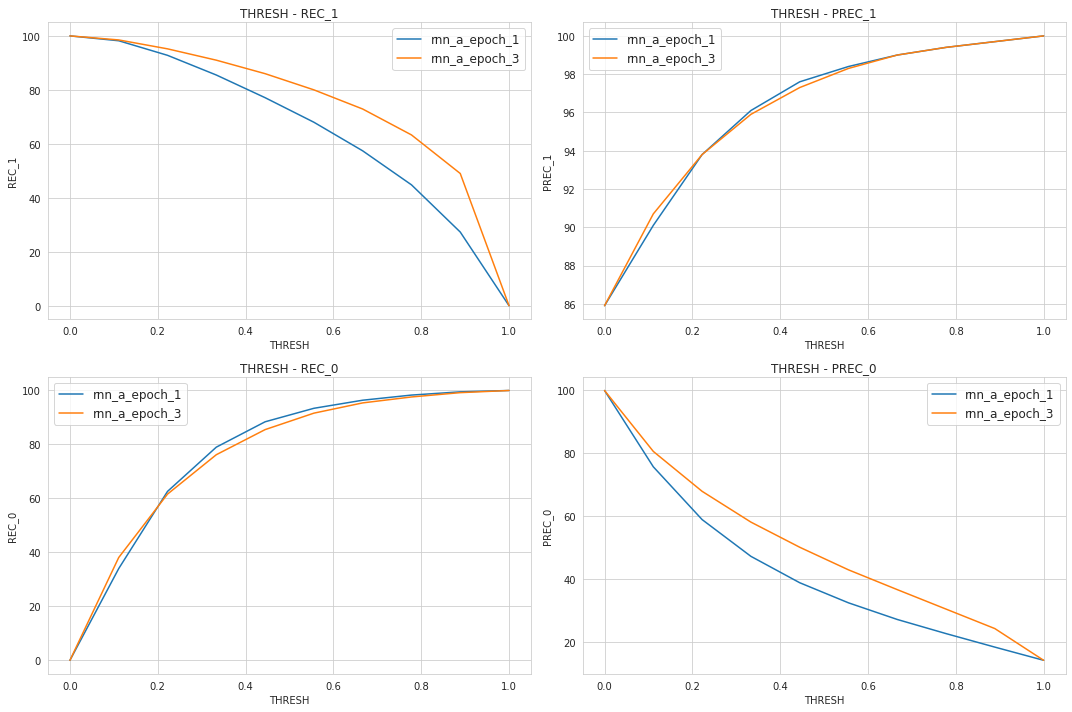

In [ ]:
kwargs = dict(model_save_path = data_path + 'RNN_MODELS/model_a/')
listO_filtered_models_2 = [fn_load(i, **kwargs) for i in list(df_filtered_2.index)]
df_Xy_ = df_tr
legend = list(df_filtered_2.index)

fn_performance_models_data(listO_filtered_models_2, df_Xy_, legend, NN=True)

## MODEL TESTING:

In [ ]:
df_Xy_ = df_tr_

model_ =  listO_filtered_models_2[-1]
thresh = 0.5

fn_test_model_binary_clf(df_Xy_, model_, threshold_class_1 = thresh)

--------------------
LOGLOSS : 0.3453
ACCURACY: 83.979
--------------------



,prec,rec
class_0,46.4,88.9
class_1,97.9,83.2


In [ ]:
df_Xy_ = df_ts_

fn_test_model_binary_clf(df_Xy_, model_, threshold_class_1 = thresh)

--------------------
LOGLOSS : 0.374
ACCURACY: 81.983
--------------------



,prec,rec
class_0,42.7,81.4
class_1,96.4,82.1


-----------

# BIDIRECTIONAL LSTM:

In [ ]:
from tensorflow.keras.layers import  LSTM

In [ ]:
model_b = Sequential(name = 'rnn_b')

model_b.add(Embedding(vocab_size+1, 100))

model_b.add(Bidirectional(LSTM(100, return_sequences=True)))
model_b.add(keras.layers.Dropout(0.1))

model_b.add(LSTM(100, return_sequences=True))
model_b.add(LSTM(50, return_sequences=False))

model_b.add(Dense(1, activation='sigmoid'))

model_b.summary()

Model: "rnn_b"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         6585500   
_________________________________________________________________
bidirectional (Bidirectional (None, None, 200)         160800    
_________________________________________________________________
dropout (Dropout)            (None, None, 200)         0         
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 100)         120400    
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 6,896,951
Trainable params: 6,896,951
Non-trainable params: 0
___________________________________________________

In [ ]:
model = model_b
optimizer=tf.keras.optimizers.Adamax()

df_tr_, df_ts_ = df_tr, df_ts
model_save_path =  data_path + 'RNN_MODELS/model_b/'

batch_size, epochs = 150, 5
class_bias = {0:87, 1:13}

z = fn_NN_binary_clf(model, optimizer, df_tr_, df_ts_, model_save_path,
                     batch_size=batch_size, epochs=epochs,
                     class_weight = class_bias)

df_performance_model_rnn_b, df_history_rnn_b = z

In [ ]:
regd_columns = 'tr_prec_1 tr_rec_1 tr_prec_0 tr_rec_0 diff_rec_1 diff_rec_0'.split()

In [ ]:
dff = df_performance_model_rnn_b
df1 = dff[dff.diff_rec_0 < 0.06]
df2 = df1[df1.diff_rec_1 < 0.06]
df3 = df2[df2.tr_rec_0 > 0.6]
df_filtered_b = df3[df3.tr_rec_0 > 0.6]
df_filtered_b.loc[:, regd_columns]

,tr_prec_1,tr_rec_1,tr_prec_0,tr_rec_0,diff_rec_1,diff_rec_0
rnn_b_epoch_1,0.972631,0.798917,0.412942,0.862858,0.012976,0.038277
rnn_b_epoch_2,0.976975,0.809385,0.431787,0.883631,0.023662,0.032699
rnn_b_epoch_3,0.979522,0.821973,0.451834,0.895172,0.039308,0.040777


In [ ]:
def fn_load(model_name, model_save_path = model_save_path):
    model_name = model_save_path + model_name + '.h5'
    return keras.models.load_model(model_name)

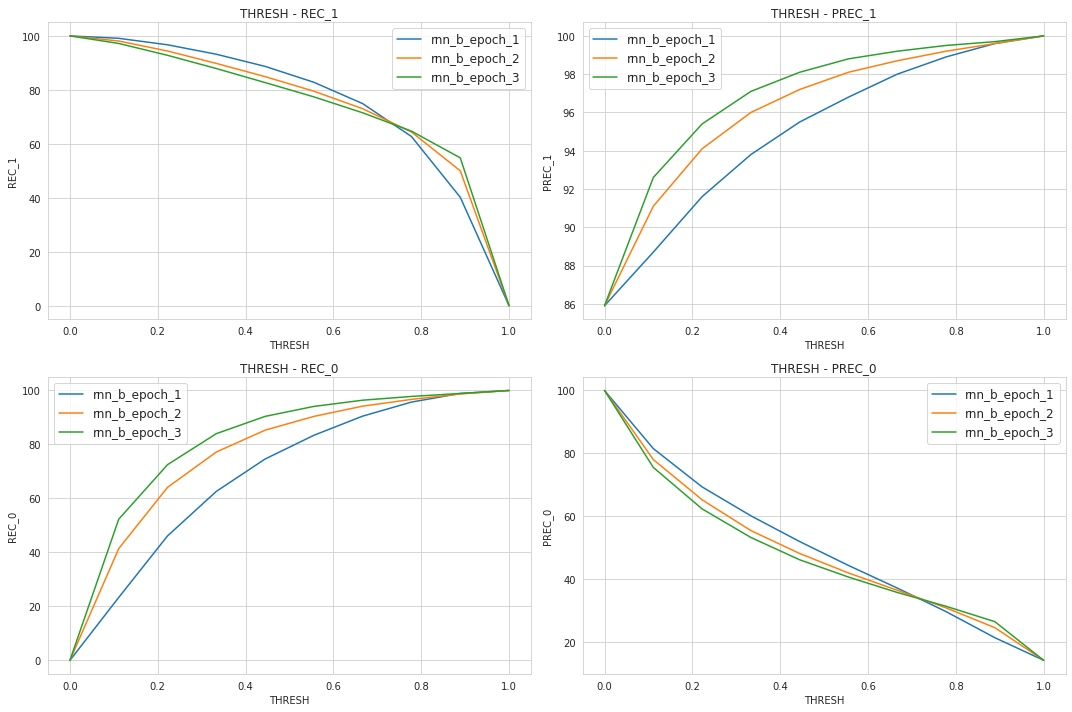

In [ ]:
kwargs = dict(model_save_path = data_path + 'RNN_MODELS/model_b/')
listO_filtered_models_b = [fn_load(i, **kwargs) for i in list(df_filtered_b.index)]
df_Xy_ = df_tr
legend = list(df_filtered_b.index)

fn_performance_models_data(listO_filtered_models_b, df_Xy_, legend, NN=True)

In [ ]:
df_Xy_ = df_tr

model_ =  listO_filtered_models_b[-2]
thresh = 0.5

fn_test_model_binary_clf(df_Xy_, model_, threshold_class_1 = thresh)

--------------------
LOGLOSS : 0.3614
ACCURACY: 83.062
--------------------



,prec,rec
class_0,44.8,88.1
class_1,97.7,82.2


In [ ]:
df_Xy_ = df_ts

fn_test_model_binary_clf(df_Xy_, model_, threshold_class_1 = thresh)

--------------------
LOGLOSS : 0.388
ACCURACY: 81.368
--------------------



,prec,rec
class_0,41.8,82.5
class_1,96.6,81.2
